In [1]:
%load_ext autoreload

# *Learning Redundancy in Supply Chain Networks: Analysis of Topological and Structural Signals*

**Goal**: Calculate and predict *real* supply chain redundancy. Comparing the use of structural metrics vs using topological metrics vs using both metrics during learning. 

**Motivation**: There is a problem of the problem with the *illusion* of redundancy in supply chain networks. Supply chain audits rely on degree, number of suppliers, number of routes, but these fail to detect shared failure modes, meaning that "redundant" edges or nodes may not be redundant at all.

**Structural Metrics:** Quantify local geometry and path-based properties of the graph. These metrics are typically sensitive to degrees, distances, and flow-like behavior, but do not explicitly encode higher-order connectivity.
- Degree change: Measures whether removal of X locally alters node connectivity.
- Shortest-path distortion: Captures whether alternative routes preserve path efficiency.
- Edge / node betweenness change: Measures whether traffic or flow is re-routed through different parts of the network after removal.
- Local efficiency: Quantifies robustness of information exchange in the neighborhood.
- Spectral stability: Measures sensitivity of the graph Laplacian spectrum to removal.

**Topological Metrics:** Quantify higher-order connectivity and redundancy of paths, capturing global structural features that persist across scales. Initial idea is that topological redundancy reflects whether X participates in persistent alternative structures rather than merely short local detours.
- Connected components (0-dimensional homology): Detects whether removal disconnects the graph.
- Cycle persistence (1-dimensional homology): Measures destruction of cycles that encode alternative pathways.
- Total persistence: Captures how much “redundancy mass” is lost.
- Loop stability across filtrations: Evaluates whether cycles persist under multiple edge-weight or distance filtrations.

---

# *Defining Redundancy of a Supply Chain Route*

### What is Route/Edge Redundancy?

**In general:** Let X be an edge or set of connected edges. Remove X from G to produce new graph G\X. X is redundant if change between G and G\X is negligible under a chosen family of structural and topological metrics.

**In a Supply Chain Network:** Let X be an edge or set of connected edges. Remove X from G to produce new graph G\X. X is redundant if the removal of X causes only negligible impact on the network’s ability to deliver materials or products to all nodes. More concretely, X is redundant if:
- Reachability is largely preserved: Most or all nodes can still be reached from their sources after removing X
- Delivery efficiency is minimally affected: The time, distance, or cost required to move products through the network changes only slightly for the nodes that remain reachable.

In other words, redundancy measures whether X participates in critical pathways or whether alternative routes and structures exist that allow the supply chain to function effectively even in its absence. 

### Creating a Redundancy Score for any X

With those definitions in mind, we will define a set of edges \(X\)'s *redundancy score* as:
$$
R(X) = 
\sum_{v \in V_{\text{reachable}}} \big( t_{G \setminus X}(v) - t_G(v) \big) 
+ \lambda \cdot |V_{\text{unreachable}}|
$$

where:  

- $V_{\text{reachable}}$ is the set of nodes still reachable after removing $X$,  
- $V_{\text{unreachable}}$ is the set of nodes that can no longer be reached,  
- $t_G(v)$ is the time (or number of weighted steps) it takes for node $v$ to receive material in the original graph $G$,  
- $t_{G \setminus X}(v)$ is the corresponding time in the modified graph $G \setminus X$,  
- $\lambda$ is a large (and negative) penalty weight for unreachable nodes. Large because unreachable nodes should dominate delay.

The greater the redundancy score $R(X)$, the more redundant $X$ is and vice versa.


---
# *Creating a Redundancy Scorer*

### Reducing Complexity of Computing the Score

Computing $R(X)$ exactly for every candidate removal $X$ during training can be expensive (we would be recomputing a diffusion or flow simulation per $X$). We can instead approximate $R(X)$ using diffusion and the heat equation:

- Model diffusion by the heat equation on the graph Laplacian $L$. Start from an initial source signal $f(0)$ (e.g., supply injection at source nodes). The diffusion at time $t$ is $ f(t) = e^{-tL} f(0) $

- Define the arrival time of node $v$ in graph $G$ as the first time its diffused mass crosses a threshold $\tau$. That is, let $t_G(v) = \min\{ t \ge 0 : f_v(t) \ge \tau \}$. 

- Then the redundancy score is $R(X) = \sum_{v \in V_{\text{reachable}}} \big(t_{G\setminus X}(v) - t_G(v)\big) + \lambda \cdot |V_{\text{unreachable}}|$

To do spectral (fast) approximation, we compute just the top $k$ eigenpairs $(\lambda_i, \phi_i)$ of $L$ (once), and use the truncated heat kernel $e^{-tL} \approx \sum_{i=1}^k e^{-t\lambda_i} \phi_i \phi_i^\top$. When an edge set $X$ is removed, the Laplacian changes by a sparse perturbation $\Delta L$. Use first-order perturbation to update eigenvalues $\tilde\lambda_i \approx \lambda_i + \phi_i^\top (\Delta L) \phi_i$ and recompute the truncated sum with $\tilde\lambda_i$. Arrival times $t_{G\setminus X}(v)$ are then derived from the approximated $f_{G\setminus X}(t)$.

Note that we will consider a node v unreachable if its diffusion signal never crosses the arrival threshold $\tau$ within a maximum time horizon $T_{max}$


### Choice of Diffusion for Redundancy Metric

1. Single vs Multiple Sources? 

   Multiple sources. Most supply chains have several suppliers or warehouses feeding the network simultaneously. Modeling diffusion from multiple sources better captures real-world redundancy and alternative routing.

2. Linear vs Nonlinear Congestion? 

   Linear flow approximation. Assume that the “flow” of material is proportional to edge capacities and additive. Nonlinear congestion (e.g., queueing, bottlenecks) could be modeled in the future, but linear flow keeps computation tractable for large graphs.

3. Steady-state vs Transient Dynamics?  

   Transient dynamics. Measure how long it takes nodes to receive material after removing $X$, rather than just the steady-state distribution. This aligns with our delay-based redundancy score $R(X)$ and captures the temporal fragility of the network.

Note that our $R(X)$ metric is highly dependent on the diffusion model we choose! Future work could involve changing the diffusion choice used.

### Create Redundancy Scorer

In [2]:
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import eigsh
from typing import List, Tuple, Dict, Optional
import warnings


import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

def precompute_eigenpairs(G: nx.Graph, k: int, laplacian_kind: str = 'combinatorial', tol_zero=1e-9):
    """
    Compute the smallest k *non-trivial* eigenpairs of the graph Laplacian.

    This function builds the (combinatorial) graph Laplacian L = D - W and
    computes its eigenvalues and eigenvectors. Eigenvalues close to zero
    correspond to connected components and are excluded.

    Parameters
    ----------
    G : nx.Graph
        Undirected, weighted graph.
        Edge weights are assumed to be non-negative and stored under the
        'weight' attribute (default = 1.0 if missing).

    k : int
        Number of *non-zero* Laplacian eigenpairs to return.
        These correspond to the lowest-frequency (smoothest) modes.

    laplacian_kind : str
        Currently unused; reserved for future extension (e.g. normalized Laplacian).

    tol_zero : float
        Numerical threshold below which an eigenvalue is considered zero
        (i.e., part of the nullspace / connected components).

    Returns
    -------
    eigvals : np.ndarray, shape (k,)
        The smallest k non-zero Laplacian eigenvalues.

    eigvecs : np.ndarray, shape (n, k)
        Corresponding eigenvectors, stored column-wise.
        eigvecs[:, i] corresponds to eigvals[i].
    """
    n = G.number_of_nodes()
    if n == 0:
        return np.array([]), np.zeros((0, 0))

    # Build combinatorial Laplacian L = D - W (dense, then to sparse)
    nodes = list(G.nodes())
    idx = {node: i for i, node in enumerate(nodes)}
    W = np.zeros((n, n))
    for u, v, data in G.edges(data=True):
        i, j = idx[u], idx[v]
        w = data.get('weight', 1.0)
        W[i, j] = w
        W[j, i] = w
    D = np.diag(W.sum(axis=1))
    L = D - W
    L_sparse = csr_matrix(L)

    # We will request m eigenpairs from eigsh where m = min(k + n_extra, n - 1)
    # n - 1 ensures eigsh does not get asked to compute all n eigenpairs.
    # Small graphs -> fallback to dense eigh reliably.
    m = min(k + 5, max(1, n - 1))  # request few extra to ensure we can drop near-zero
    try:
        eigvals_all, eigvecs_all = eigsh(L_sparse, k=m, which='SM')  # smallest magnitude
    except Exception:
        # fallback to dense, reliable
        eigvals_all, eigvecs_all = np.linalg.eigh(L)
    # Sort ascending
    order = np.argsort(eigvals_all)
    eigvals_all = eigvals_all[order]
    eigvecs_all = eigvecs_all[:, order]

    # Drop near-zero eigenvalues (trivial components). Keep next k eigenpairs.
    keep_idxs = [i for i, val in enumerate(eigvals_all) if val > tol_zero]
    if len(keep_idxs) < k:
        # If we don't have enough non-zero eigenvalues in the small set,
        # fall back to dense full eigen-decomp (safe for modest n).
        if n <= 2000:  # adjust threshold by your memory
            eigvals_full, eigvecs_full = np.linalg.eigh(L)
            order_full = np.argsort(eigvals_full)
            eigvals_full = eigvals_full[order_full]
            eigvecs_full = eigvecs_full[:, order_full]
            keep_idxs = [i for i, val in enumerate(eigvals_full) if val > tol_zero]
            take = keep_idxs[:k]
            eigvals = eigvals_full[take]
            eigvecs = eigvecs_full[:, take]
            return eigvals, eigvecs
        else:
            # Otherwise, pad with the smallest available non-zero eigenpairs
            # (this is a fallback but will still work numerically)
            take = keep_idxs[:k]
            eigvals = eigvals_all[take]
            eigvecs = eigvecs_all[:, take]
            return eigvals, eigvecs

    # Normal case: take first k non-zero eigenpairs from eigvals_all
    take = keep_idxs[:k]
    eigvals = eigvals_all[take]
    eigvecs = eigvecs_all[:, take]
    return eigvals, eigvecs



def compute_delta_L_for_edges(G: nx.Graph, X: List[Tuple]) -> np.ndarray:
    """
    Compute the change in the Laplacian matrix ΔL caused by removing edges X.

    For a single edge (u, v) with weight w:
        ΔL = -w (e_u - e_v)(e_u - e_v)^T

    For multiple edges, the contributions are summed.

    Parameters
    ----------
    G : nx.Graph
        Original weighted graph.

    X : List[Tuple]
        List of edges to remove, where each edge is given as (u, v).

    Returns
    -------
    delta_L : np.ndarray, shape (n, n)
        Dense matrix representing the change in the Laplacian.
        This matrix is negative semi-definite.
    """
    n = G.number_of_nodes()
    nodes = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    delta_L = np.zeros((n, n))
    
    for u, v in X:
        if not G.has_edge(u, v):
            continue  # Edge doesn't exist, skip
        
        i, j = node_to_idx[u], node_to_idx[v]
        weight = G[u][v].get('weight', 1.0)
        
        # Rank-1 update: -w * (e_i - e_j)(e_i - e_j)^T
        diff = np.zeros(n)
        diff[i] = 1.0
        diff[j] = -1.0
        delta_L -= weight * np.outer(diff, diff)
    
    return delta_L


def approx_eigen_updates(phis: np.ndarray, deltaL: np.ndarray) -> np.ndarray:
    """
    Approximate changes to Laplacian eigenvalues using first-order perturbation theory.

    For eigenpair (λ_i, φ_i):
        δλ_i ≈ φ_i^T ΔL φ_i

    Parameters
    ----------
    phis : np.ndarray, shape (n, k)
        Eigenvectors of the original Laplacian.

    deltaL : np.ndarray, shape (n, n)
        Change in Laplacian due to edge removals.

    Returns
    -------
    delta_lambdas : np.ndarray, shape (k,)
        Approximate change to each eigenvalue.
    """
    k = phis.shape[1]
    delta_lambdas = np.zeros(k)
    
    for i in range(k):
        phi_i = phis[:, i]
        # First-order perturbation: δλ_i = φ_i^T ΔL φ_i
        delta_lambdas[i] = phi_i.T @ deltaL @ phi_i
    
    return delta_lambdas

def resolve_eval_nodes(eval_nodes, node_to_idx, n):
    """
    Accept eval_nodes as:
    - None -> returns list(range(n))
    - list of node IDs -> maps to indices using node_to_idx (skips unknown IDs)
    - list of integer indices -> if all in 0..n-1, use directly
    Returns list of indices.
    """
    if eval_nodes is None:
        return list(range(n))
    # try mapping each element; if element is present in node_to_idx, map; else if integer in range, accept
    out = []
    for item in eval_nodes:
        if item in node_to_idx:
            out.append(node_to_idx[item])
        elif isinstance(item, int) and 0 <= item < n:
            out.append(item)
        else:
            # skip unknown id with warning
            warnings.warn(f"Skipping unknown eval node {item}")
    return out


def heat_arrival_times_from_eigs_with_zero(
    eigs: np.ndarray,           # shape (k,) : nonzero eigenvalues (k may be 0)
    phis: np.ndarray,           # shape (n, k)
    f0: np.ndarray,             # shape (n,)
    tau: float,
    t_grid: np.ndarray,
    eval_indices: Optional[List[int]] = None
) -> Dict[int, float]:
    """
    Compute node arrival times using a truncated heat-kernel expansion,
    explicitly including the zero (constant) eigenmode.

    The signal evolution is:
        f(t) = φ₀φ₀ᵀf₀ + Σᵢ exp(-λᵢ t) φᵢφᵢᵀf₀

    Arrival time is defined as the earliest t such that f_v(t) ≥ tau.

    Parameters
    ----------
    eigs : np.ndarray, shape (k,)
        Non-zero Laplacian eigenvalues.

    phis : np.ndarray, shape (n, k)
        Corresponding eigenvectors.

    f0 : np.ndarray, shape (n,)
        Initial signal (typically 1 at sources, 0 elsewhere).

    tau : float
        Threshold defining “arrival”.

    t_grid : np.ndarray
        Discrete time grid.

    eval_indices : list[int] or None
        Node indices to evaluate.

    Returns
    -------
    arrival_times : Dict[int, float]
        Mapping node_index → arrival time.
        np.inf indicates no arrival within the time horizon.
    """
    n = f0.shape[0]
    if eval_indices is None:
        eval_indices = np.arange(n)
    else:
        eval_indices = np.array(eval_indices, dtype=int)

    # zero-mode (constant eigenvector) contribution
    phi0 = np.ones(n) / np.sqrt(n)          # normalized constant eigenvector
    coeff0 = float(phi0 @ f0)               # scalar
    # contribution at any time from zero-mode: phi0 * coeff0 (time-invariant)

    # truncated nonzero modes (may be empty)
    if phis is None or phis.size == 0:
        # only zero-mode contributes
        # steady state value at each node:
        steady = (phi0 * coeff0)[eval_indices]
        arrival = {}
        for idx, node_idx in enumerate(eval_indices):
            val = steady[idx]
            arrival[int(node_idx)] = 0.0 if val >= tau else np.inf
        return arrival

    # compute coefficients for nonzero modes
    coeffs = phis.T @ f0   # shape (k,)

    # phi_eval shape: (n_eval, k)
    phi_eval = phis[eval_indices, :]   # (n_eval, k)

    # Build exp(-t * eigs) matrix: (T, k)
    exp_mat = np.exp(-np.outer(t_grid, eigs))   # (T, k)

    # Weighted contributions: for each t, vector w_t = exp(-t*eigs) * coeffs
    # Then f_nonzero(t) at eval nodes = phi_eval @ w_t.T
    # Do matmul: F_nonzero = exp_mat * coeffs  -> (T, k) elementwise multiply
    F_nonzero = (exp_mat * coeffs[np.newaxis, :]) @ phi_eval.T   # (T, n_eval)

    # Zero-mode steady contribution per eval node:
    steady_zero = (phi0 * coeff0)[eval_indices]   # (n_eval,)

    # Total F over time: F = F_nonzero + steady_zero (broadcast steady_zero along t axis)
    Tlen = len(t_grid)
    # Detect arrival times: first t where F[:, j] + steady_zero[j] >= tau
    arrival_times = {}
    # We'll vectorize detection
    F_total = F_nonzero + steady_zero[np.newaxis, :]   # (T, n_eval)

    # For numerical robustness, treat small negatives as zeros
    # Now find first index per column where >= tau
    reached_mask = F_total >= tau   # (T, n_eval)
    # For columns where any True, argmax returns first True, else 0 - we need to detect no-True
    any_reached = reached_mask.any(axis=0)   # (n_eval,)
    first_idx = np.argmax(reached_mask, axis=0)   # (n_eval,)
    for pos, node_idx in enumerate(eval_indices):
        if any_reached[pos]:
            arrival_times[int(node_idx)] = float(t_grid[first_idx[pos]])
        else:
            arrival_times[int(node_idx)] = np.inf

    return arrival_times

def nodes_reachable_after_removal(G: nx.Graph, sources: List, X: List[Tuple]) -> set:
    """
    Compute which nodes remain graph-theoretically reachable from any source
    after removing edges X. Uses a copy of G with edges removed and then a 
    multi-source BFS via components.

    Parameters
    ----------
    G : nx.Graph
        Original graph.

    sources : list
        Source node IDs.

    X : list[tuple]
        Edges to remove.

    Returns
    -------
    reachable : set
        Set of node IDs reachable from at least one source in G \\ X.
    """
    G_removed = G.copy()
    for (u, v) in X:
        if G_removed.has_edge(u, v):
            G_removed.remove_edge(u, v)
    reachable = set()
    for s in sources:
        if s in G_removed:
            # add the entire connected component of s
            try:
                comp = nx.node_connected_component(G_removed, s)
            except Exception:
                # fallback: single_source_shortest_path_length
                comp = set(nx.single_source_shortest_path_length(G_removed, s).keys())
            reachable.update(comp)
    return reachable


def compute_redundancy_score(
    G: nx.Graph,
    sources: List,
    X: List[Tuple],
    params: Optional[Dict] = None
) -> Tuple[float, Dict]:
    """
    Compute a redundancy score for an edge set X by measuring how much
    removing X delays or blocks diffusion from sources.

    The score combines:
    - Total diffusion delay over reachable nodes
    - A penalty proportional to the number of unreachable nodes

    Returns a normalized redundancy score and detailed diagnostics.

    Returns
    -------
    R_norm : float
        Redundancy score in [0, 100], where higher = more redundant.

    diagnostics : Dict
        Contains:
        - 'R_raw' : unnormalized disruption
        - 'R' : normalized disruption
        - 'num_unreachable' : number of unreachable nodes
        - 'total_delay' : sum of delays
        - 'node_delays' : dict {node_index → delay or inf}
        - 'reachable_node_ids_after_removal' : set of node IDs
        - 'method' : string identifier
        - optionally 'eigen_deltas'
    """
    # Default parameters (lambda_penalty positive = disruption cost)
    defaults = {
        'k_eig': 20,
        'tau': 0.1,
        'lambda_penalty': 1000.0,
        'ego_radius': None,
        'eval_nodes': None,
        'return_deltas': False,
        'T_max': 10.0,
        'dt': 0.01
    }
    if params is None:
        params = {}
    params = {**defaults, **params}

    # Node list and mapping
    nodes = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    idx_to_node = {i: node for node, i in node_to_idx.items()}
    n = len(nodes)

    # Build initial signal f0 (vector on node indices)
    f0 = np.zeros(n)
    for s in sources:
        if s in node_to_idx:
            f0[node_to_idx[s]] = 1.0

    # Precompute eigenpairs for original graph (nonzero modes)
    k_eig = min(params['k_eig'], max(1, n - 1))
    lambdas, phis = precompute_eigenpairs(G, k_eig)

    # Time grid
    t_grid = np.arange(0, params['T_max'] + params['dt'], params['dt'])

    # Determine eval nodes (use ego radius if provided, else full graph or params['eval_nodes'])
    if params['eval_nodes'] is None and params['ego_radius'] is not None:
        # compute ego nodes around edges in X
        ego_nodes = set()
        for (u, v) in X:
            if u in G and v in G:
                # nodes within radius r of u and v
                try:
                    du = nx.single_source_shortest_path_length(G, u, cutoff=params['ego_radius'])
                    dv = nx.single_source_shortest_path_length(G, v, cutoff=params['ego_radius'])
                    ego_nodes.update(du.keys())
                    ego_nodes.update(dv.keys())
                except Exception:
                    pass
        eval_nodes_input = list(ego_nodes)
    else:
        eval_nodes_input = params['eval_nodes']  # may be None (interpreted as all)

    # Resolve eval nodes into indices (robust)
    eval_indices = resolve_eval_nodes(eval_nodes_input, node_to_idx, n)

    # Compute baseline arrival times on original G
    arrival_times_G = heat_arrival_times_from_eigs_with_zero(
        lambdas, phis, f0, params['tau'], t_grid, eval_indices
    )

    # Compute reachable nodes after removal of X (using graph connectivity)
    reachable_node_ids = nodes_reachable_after_removal(G, sources, X)

    # Compute ΔL for removed edges (for eigen perturbation)
    delta_L = compute_delta_L_for_edges(G, X)

    # Approximate eigenvalue updates (first order)
    delta_lambdas = approx_eigen_updates(phis, delta_L)
    lambdas_perturbed = lambdas + delta_lambdas
    lambdas_perturbed = np.maximum(lambdas_perturbed, 1e-12)

    # Compute arrival times from spectral approx for G\X (for all eval indices)
    arrival_times_G_X_spec = heat_arrival_times_from_eigs_with_zero(
        lambdas_perturbed, phis, f0, params['tau'], t_grid, eval_indices
    )

    # Now **enforce true reachability**: nodes not in reachable_node_ids are unreachable
    arrival_times_G_X = {}
    for idx in eval_indices:
        node_id = idx_to_node[idx]
        if node_id not in reachable_node_ids:
            arrival_times_G_X[idx] = np.inf
        else:
            # use spectral estimate if available; fallback to inf
            arrival_times_G_X[idx] = arrival_times_G_X_spec.get(idx, np.inf)

    # Compute delays and unreachable count
    node_delays = {}
    num_unreachable = 0
    total_delay = 0.0
    for v_idx in eval_indices:
        t_G = arrival_times_G.get(v_idx, np.inf)
        t_G_X = arrival_times_G_X.get(v_idx, np.inf)

        if np.isinf(t_G_X):
            num_unreachable += 1
            node_delays[v_idx] = np.inf
        else:
            # delay: if original was inf but now reachable, treat delay = t_G_X (or consider as large)
            if np.isinf(t_G):
                delay = t_G_X
            else:
                delay = max(0.0, t_G_X - t_G)
            node_delays[v_idx] = delay
            total_delay += delay

    # Compute raw disruption metric (higher = more disruptive)
    R_raw = total_delay + params['lambda_penalty'] * num_unreachable

    # Normalize into 0..100; note interpretation: higher = more disruptive
    R_max = n * params['T_max'] + params['lambda_penalty'] * n
    if R_max <= 0:
        R_norm = R_raw
    else:
        R_norm = (R_raw / R_max) * 100.0

    # Optionally invert to express "redundancy" (lower disruption -> higher redundancy)
    # Here we return disruption R_norm; if you prefer redundancy in [0,100], do 100 - R_norm.
    diagnostics = {
        'R_raw': R_raw,
        'R': R_norm,
        'num_unreachable': num_unreachable,
        'total_delay': total_delay,
        'node_delays': node_delays,
        'reachable_node_ids_after_removal': reachable_node_ids,
        'method': 'spectral_approximation'
    }
    if params.get('return_deltas', False):
        diagnostics['eigen_deltas'] = delta_lambdas

    # so that higher R_norm = more redundant
    R_norm = 100 - R_norm
    return R_norm, diagnostics



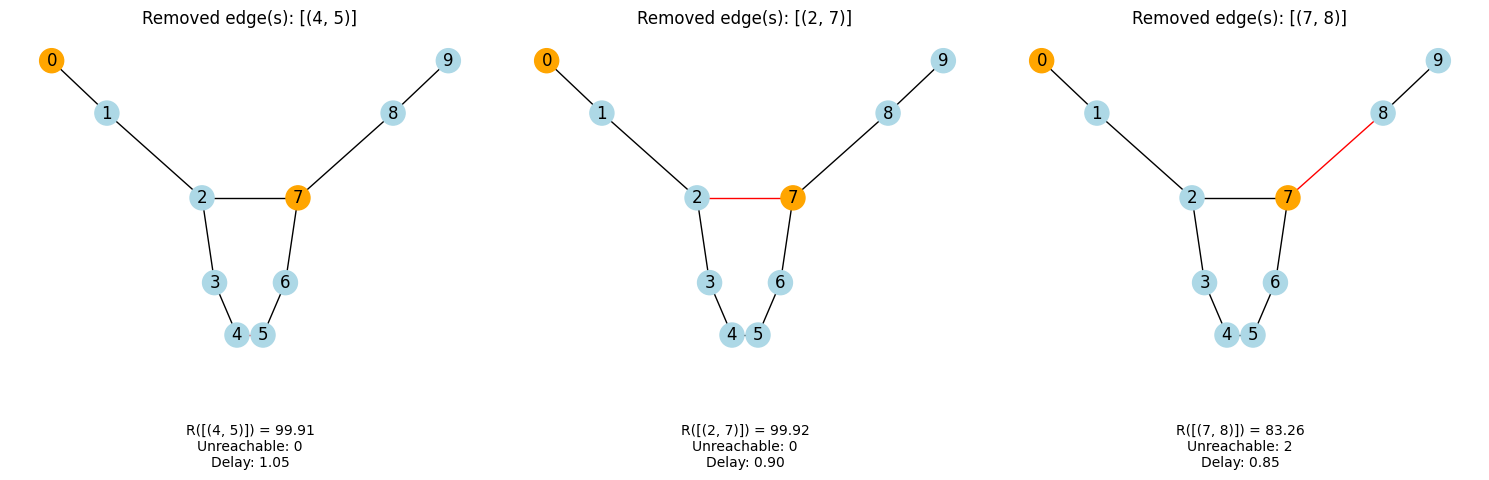

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

#  Graph setup
G_test = nx.Graph()
for i in range(9):
    G_test.add_edge(i, i + 1, weight=1.0)
G_test.add_edge(2, 7, weight=1.0)

sources_test = [0, 7]
fixed_pos = nx.spectral_layout(G_test)

X_set = [[(4, 5)], [(2, 7)], [(7, 8)]]

# Node coloring
def node_colors(G, sources):
    return ['orange' if n in sources else 'lightblue' for n in G.nodes()]

# -Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, X in enumerate(X_set):

    R_bridge, diag_bridge = compute_redundancy_score(
        G_test,
        sources_test,
        X,
        params={'k_eig': 20, 'tau': 0.1, 'lambda_penalty': 100.0, 'T_max': 20.0, 'dt': 0.05}
    )

    # Copy graph
    second_graph = G_test.copy()

    # Edge coloring
    edge_colors = {e: 'black' for e in second_graph.edges()}
    for e in X:
        if second_graph.has_edge(*e):
            edge_colors[e] = 'red'

    edge_color_list = [edge_colors[e] for e in second_graph.edges()]

    # Draw
    nx.draw_networkx(
        second_graph,
        pos=fixed_pos,
        ax=axes[i],
        with_labels=True,
        node_color=node_colors(second_graph, sources_test),
        edge_color=edge_color_list
    )

    axes[i].set_title(f"Removed edge(s): {X}")
    axes[i].axis('off')

    # Metrics under subplot (axis-relative coordinates)
    axes[i].text(
        0.5,
        -0.18,
        f"R({X}) = {R_bridge:.2f}\n"
        f"Unreachable: {diag_bridge['num_unreachable']}\n"
        f"Delay: {diag_bridge['total_delay']:.2f}",
        ha='center',
        va='top',
        fontsize=10,
        transform=axes[i].transAxes
    )

plt.tight_layout()
plt.show()


# *Creating Synthetic Dataset*

### Why Create and Train on Synthetic Data?

R(X), our network metric of interest, is independent of where the data comes from and the information held by the network. We are training to predict a characteristic of a network itself, not something about the information within the network. This, along with the fact that network datasets are hard to find and we need alot to train our GNNs, leads us to create a synthetic dataset rather than trying to obtain one from another source. To make this synthetic dataset, I will use NetworkX's graph generators.

### Important Considerations When Creating the Dataset

Specs are in the README of the `synthetic-graphs` folder

### Dataset Creation using NetworkX

In [4]:
# reload python script

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append(str(Path.cwd()))

from generate_synthetic_dataset import (
    generate_dataset,
    split_dataset,
    CONFIG
)


# Generate the dataset

data_list = generate_dataset(compute_redundancy_score=compute_redundancy_score)

print(f"Generated {len(data_list)} graphs")

if len(data_list) == 0:
    raise RuntimeError("Dataset is empty — aborting save.")

# split dataset

train_data, val_data, test_data = split_dataset(data_list)

print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")

# create output directory

output_dir = Path(CONFIG["output_dir"])
output_dir.mkdir(parents=True, exist_ok=True)

# save dataset

train_path = output_dir / "train.pt"
val_path   = output_dir / "val.pt"
test_path  = output_dir / "test.pt"

torch.save(train_data, train_path)
torch.save(val_data, val_path)
torch.save(test_data, test_path)

print("Dataset saved successfully:")
print(f"  {train_path} ({len(train_data)} graphs)")
print(f"  {val_path} ({len(val_data)} graphs)")
print(f"  {test_path} ({len(test_data)} graphs)")


/Users/juliettegarcia/Desktop/geom-final/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Generating graphs of size 50...


Graphs n=50: 100%|██████████| 300/300 [01:09<00:00,  4.33it/s]



Generating graphs of size 100...


Graphs n=100: 100%|██████████| 200/200 [04:43<00:00,  1.42s/it]



Generating graphs of size 200...


Graphs n=200: 100%|██████████| 150/150 [14:19<00:00,  5.73s/it]


Generated 620 graphs
Train: 434 | Val: 93 | Test: 93
Dataset saved successfully:
  synthetic-graphs/train.pt (434 graphs)
  synthetic-graphs/val.pt (93 graphs)
  synthetic-graphs/test.pt (93 graphs)


# *Exploring Synthetic Dataset*

In [5]:
# load dataset

train_data = torch.load("synthetic-graphs/train.pt", weights_only=False)
val_data = torch.load("synthetic-graphs/val.pt", weights_only=False)
test_data = torch.load("synthetic-graphs/test.pt", weights_only=False)

print(f"Train: {len(train_data)} graphs")
print(f"Val: {len(val_data)} graphs")
print(f"Test: {len(test_data)} graphs")

Train: 434 graphs
Val: 93 graphs
Test: 93 graphs


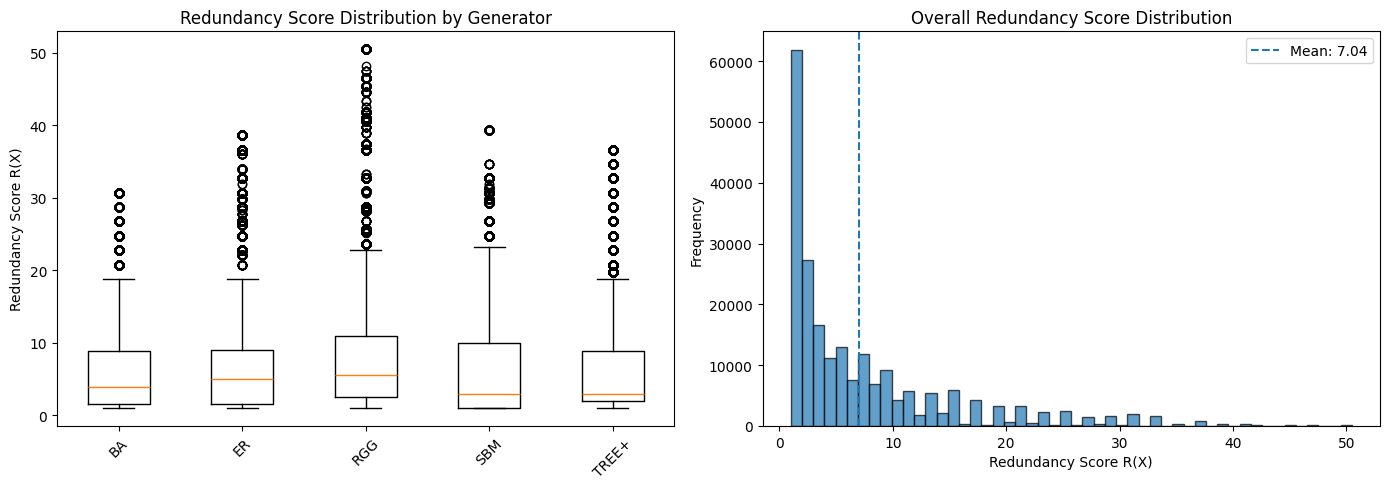

In [6]:
# Plot redundancy score distributions

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Collect redundancy scores by generator
generator_redundancy = {}

for data in data_list:
    gen_type = getattr(data, "generator", "unknown")
    scores = data.y.cpu().numpy().flatten()
    scores = scores[~np.isnan(scores)]

    if len(scores) == 0:
        continue

    generator_redundancy.setdefault(gen_type, []).extend(scores)

# Filter and sort
sorted_items = [
    (gen, scores)
    for gen, scores in sorted(generator_redundancy.items())
    if len(scores) > 0
]

if len(sorted_items) == 0:
    raise RuntimeError("No valid redundancy scores found.")

labels = [gen for gen, _ in sorted_items]
box_data = [scores for _, scores in sorted_items]

# Boxplot by generator
axes[0].boxplot(box_data)
axes[0].set_xticklabels(labels, rotation=45)
axes[0].set_ylabel("Redundancy Score R(X)")
axes[0].set_title("Redundancy Score Distribution by Generator")

# Overall distribution
all_redundancy = np.concatenate(box_data)

axes[1].hist(all_redundancy, bins=50, edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Redundancy Score R(X)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Overall Redundancy Score Distribution")
axes[1].axvline(
    np.mean(all_redundancy),
    linestyle="--",
    label=f"Mean: {np.mean(all_redundancy):.2f}"
)
axes[1].legend()

plt.tight_layout()
plt.show()


Total edges in training set: 153689

Feature summary:
             deg_sum        deg_min        deg_max  clustering_sum  \
count  153689.000000  153689.000000  153689.000000   153689.000000   
mean       19.046751       7.440032      11.606719        0.372045   
std         8.214783       3.381596       6.122513        0.428155   
min         3.000000       1.000000       2.000000        0.000000   
25%        14.000000       5.000000       8.000000        0.088889   
50%        18.000000       7.000000      11.000000        0.200000   
75%        23.000000      10.000000      14.000000        0.450000   
max       126.000000      58.000000      75.000000        2.000000   

       clustering_min  clustering_max      is_bridge         weight  \
count   153689.000000   153689.000000  153689.000000  153689.000000   
mean         0.146914        0.225131       0.012167       1.136649   
std          0.195044        0.242775       0.109633       0.605299   
min          0.000000        0

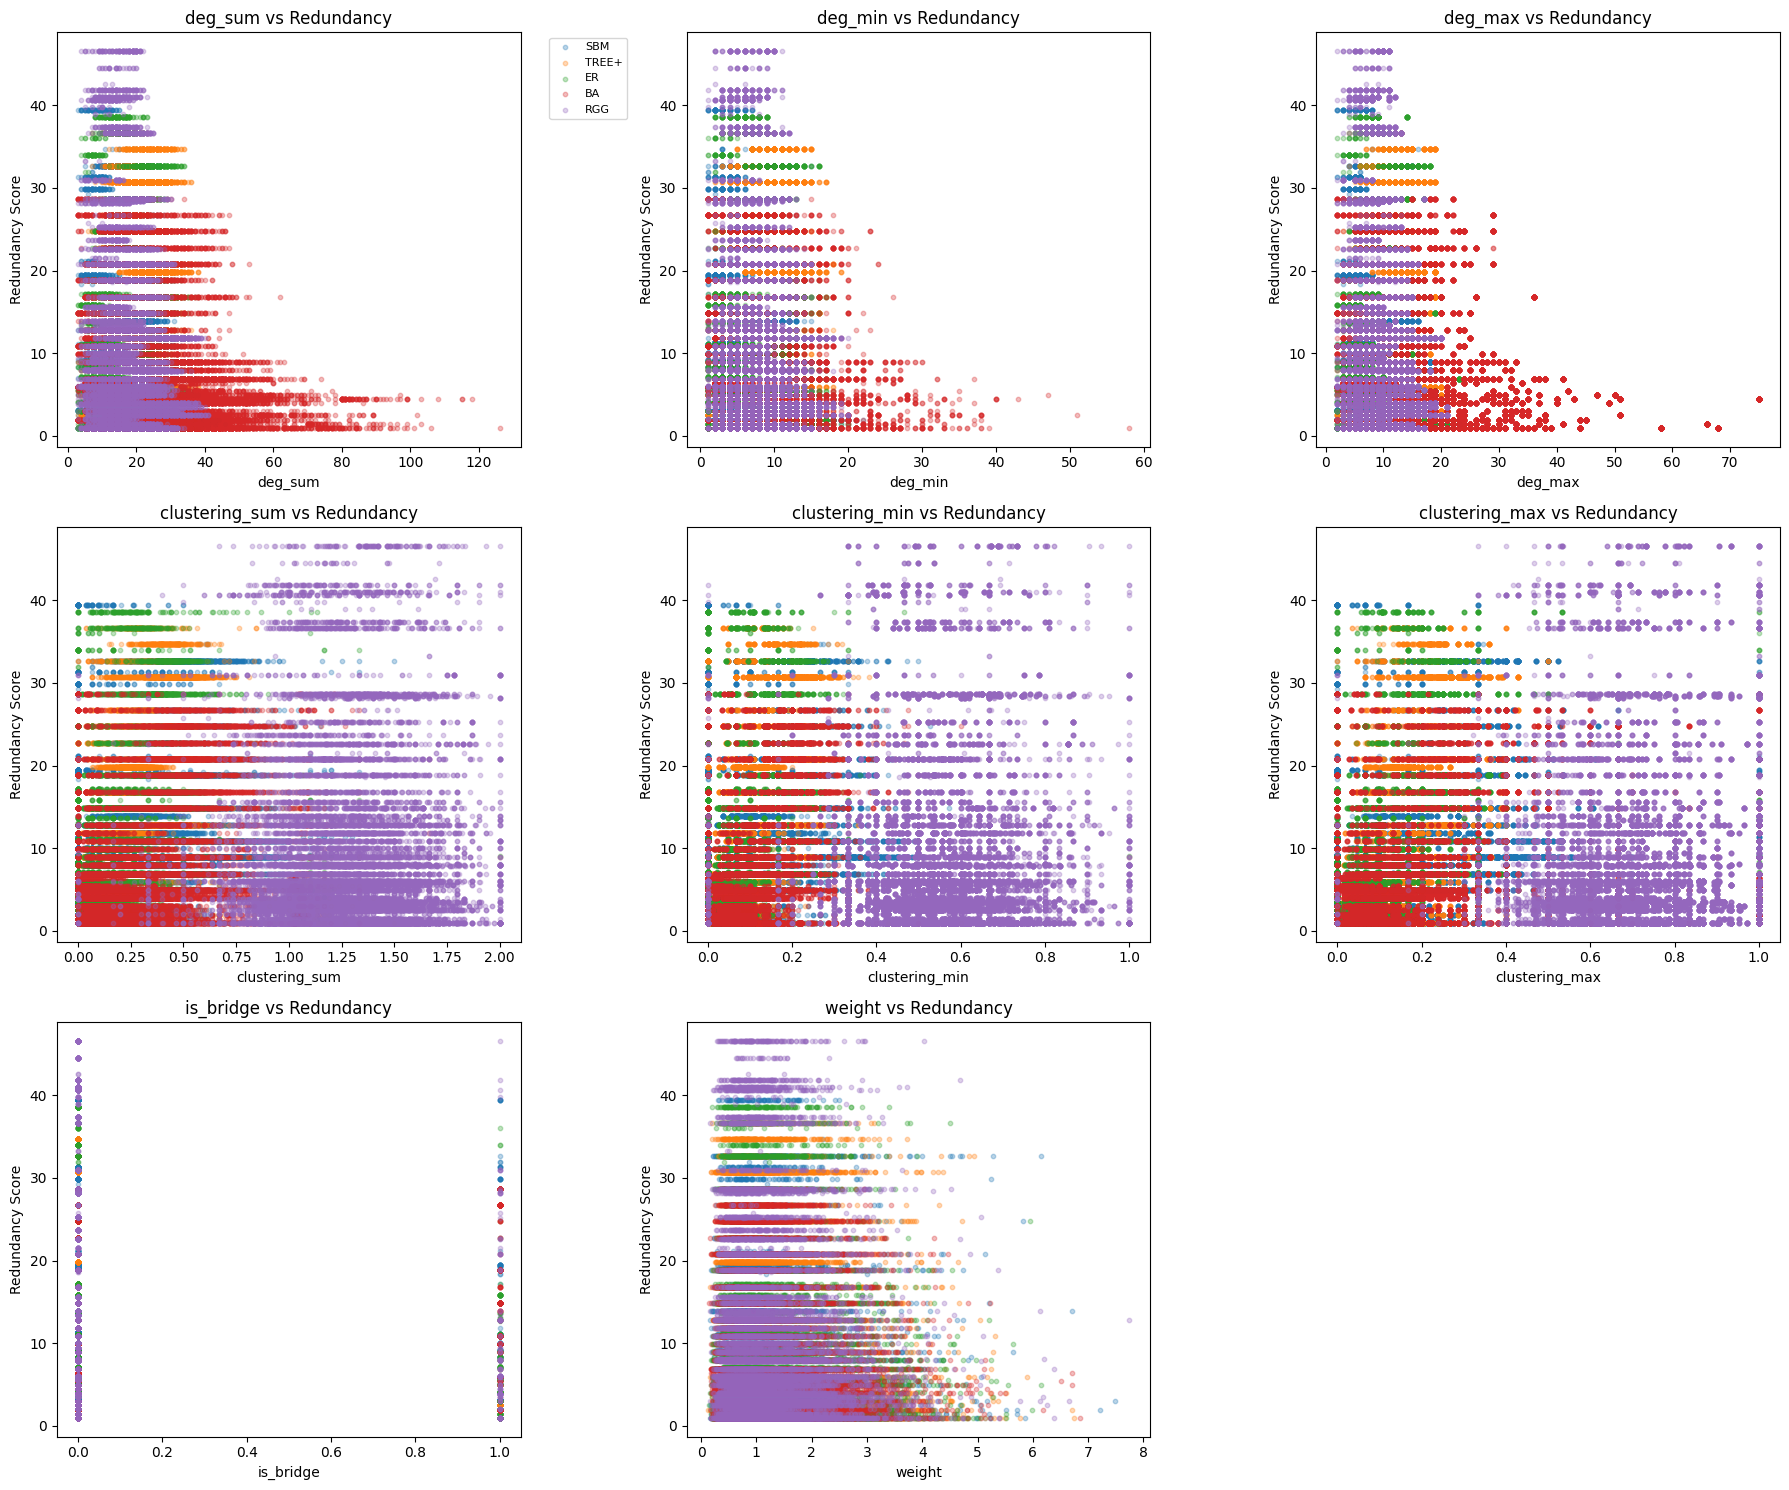

In [7]:

import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Extract per-edge features and aggregate
edge_features_list = []
redundancy_labels_list = []
generator_list = []

for data in train_data:
    # Extract quantities
    edge_index = data.edge_index.numpy().T  # [num_edges, 2]
    y = data.y.numpy().flatten()  # [num_edges]
    degrees = data.x[:, 0].numpy()  # [num_nodes]
    clustering = data.x[:, 1].numpy()  # [num_nodes]
    bridge_indicator = data.edge_attr[:, 1].numpy()  # [num_edges]
    weights = data.edge_attr[:, 0].numpy()  # [num_edges]
    generator = getattr(data, 'generator', 'unknown')
    
    # Construct per-edge feature table
    for idx, (u, v) in enumerate(edge_index):
        deg_u, deg_v = degrees[u], degrees[v]
        clust_u, clust_v = clustering[u], clustering[v]
        
        features = {
            'deg_sum': deg_u + deg_v,
            'deg_min': min(deg_u, deg_v),
            'deg_max': max(deg_u, deg_v),
            'clustering_sum': clust_u + clust_v,
            'clustering_min': min(clust_u, clust_v),
            'clustering_max': max(clust_u, clust_v),
            'is_bridge': bridge_indicator[idx],
            'weight': weights[idx],
            'redundancy': y[idx],
            'generator': generator
        }
        edge_features_list.append(features)

# Aggregate into DataFrame
df_edges = pd.DataFrame(edge_features_list)
print(f"\nTotal edges in training set: {len(df_edges)}")
print(f"\nFeature summary:")
print(df_edges.describe())

# Compute correlation statistics
print("\n" + "="*60)
print("Correlation Statistics")
print("="*60)

feature_cols = ['deg_sum', 'deg_min', 'deg_max', 'clustering_sum', 
                'clustering_min', 'clustering_max', 'is_bridge', 'weight']
correlations = []

for feat in feature_cols:
    pearson_r, pearson_p = pearsonr(df_edges[feat], df_edges['redundancy'])
    spearman_r, spearman_p = spearmanr(df_edges[feat], df_edges['redundancy'])
    correlations.append({
        'feature': feat,
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p
    })

df_corr = pd.DataFrame(correlations)
print(df_corr.to_string(index=False))

# Visualize
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, feat in enumerate(feature_cols):
    ax = axes[idx]
    
    # Scatter plot with generator coloring
    generators = df_edges['generator'].unique()
    colors = plt.cm.tab10(range(len(generators)))
    for i, gen in enumerate(generators):
        mask = df_edges['generator'] == gen
        ax.scatter(df_edges.loc[mask, feat], df_edges.loc[mask, 'redundancy'],
                  alpha=0.3, s=10, label=gen, c=[colors[i]])
    
    ax.set_xlabel(feat)
    ax.set_ylabel('Redundancy Score')
    ax.set_title(f'{feat} vs Redundancy')
    if idx == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Remove extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()



## Task 3: Redundancy vs Cycle Participation



Total edges analyzed: 153689

Cycle statistics:
       triangle_count   square_count     redundancy
count   153689.000000  153689.000000  153689.000000
mean         1.531847       1.531847       7.015603
std          2.140971       2.140971       7.855721
min          0.000000       0.000000       0.990099
25%          0.000000       0.000000       1.485149
50%          1.000000       1.000000       3.960396
75%          2.000000       2.000000       8.910892
max         24.000000      24.000000      46.534653

Correlation: Cycle Features vs Redundancy
triangle_count: r=0.1620, p=0.0000e+00
square_count: r=0.1620, p=0.0000e+00
in_cycle: r=-0.0216, p=2.6481e-17

Redundancy by Triangle Count
Triangles=0: mean=5.0752, std=6.1258, n=66213
Triangles=1: mean=7.0779, std=7.6530, n=36336
Triangles=2: mean=9.3620, std=8.9227, n=18379
Triangles=3: mean=10.3690, std=9.5251, n=10417
Triangles=4: mean=10.3069, std=9.4368, n=7065
Triangles=5: mean=9.8201, std=9.7059, n=5068
Triangles=6: mean=9.1673

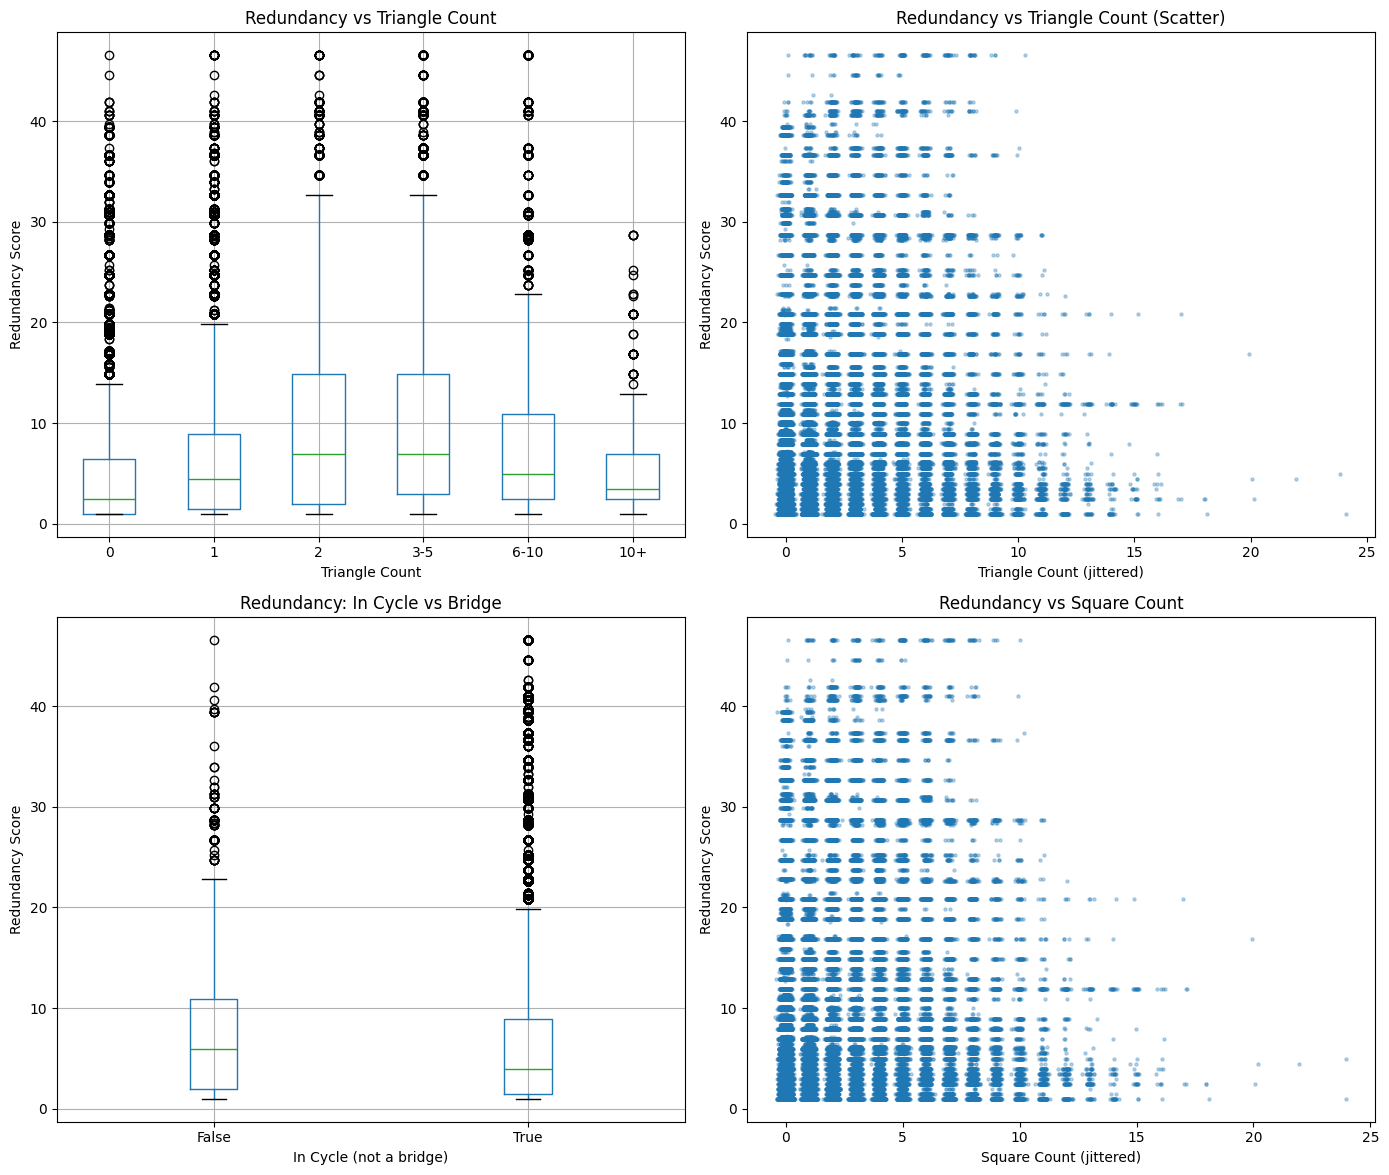

In [8]:

cycle_redundancy_pairs = []

# For each graph, compute cycle features and join with redundancy
for data in train_data:
    # Build NetworkX graph from edge_index
    edge_index = data.edge_index.numpy().T
    edge_weights = data.edge_attr[:, 0].numpy()
    redundancy_scores = data.y.numpy().flatten()
    
    G = nx.Graph()
    for idx, (u, v) in enumerate(edge_index):
        G.add_edge(int(u), int(v), weight=edge_weights[idx])
    
    # Ensure undirected (should already be)
    if not G.is_directed():
        pass  # Already undirected
    
    # Compute cycle-related features
    # Triangle count per node
    triangles = nx.triangles(G)
    
    # For each edge, count triangles it participates in
    edge_triangle_count = {}
    edge_in_cycle = {}
    
    for u, v in G.edges():
        # Triangles: count common neighbors
        common_neighbors = set(G.neighbors(u)) & set(G.neighbors(v))
        triangle_count = len(common_neighbors)
        edge_triangle_count[(u, v)] = triangle_count
        edge_triangle_count[(v, u)] = triangle_count  # Undirected
        
        # Check if edge is in any cycle (not a bridge)
        is_bridge = (u, v) in nx.bridges(G)
        edge_in_cycle[(u, v)] = not is_bridge
        edge_in_cycle[(v, u)] = not is_bridge
    
    # Square cycles (4-cycles) via two-hop paths
    edge_square_count = {}
    for u, v in G.edges():
        square_count = 0
        # Find paths of length 2 from u to v (excluding direct edge)
        for neighbor in G.neighbors(u):
            if neighbor != v and G.has_edge(neighbor, v):
                square_count += 1
        edge_square_count[(u, v)] = square_count
        edge_square_count[(v, u)] = square_count
    
    # Join with redundancy
    for idx, (u, v) in enumerate(edge_index):
        u, v = int(u), int(v)
        edge_key = (u, v) if (u, v) in edge_triangle_count else (v, u)
        
        cycle_redundancy_pairs.append({
            'triangle_count': edge_triangle_count.get(edge_key, 0),
            'square_count': edge_square_count.get(edge_key, 0),
            'in_cycle': edge_in_cycle.get(edge_key, False),
            'redundancy': redundancy_scores[idx]
        })

# Aggregate across dataset
df_cycles = pd.DataFrame(cycle_redundancy_pairs)
print(f"\nTotal edges analyzed: {len(df_cycles)}")
print(f"\nCycle statistics:")
print(df_cycles.describe())

# Analyze
print("\n" + "="*60)
print("Correlation: Cycle Features vs Redundancy")
print("="*60)

cycle_features = ['triangle_count', 'square_count', 'in_cycle']
for feat in cycle_features:
    if feat == 'in_cycle':
        # For boolean, use point-biserial correlation
        from scipy.stats import pointbiserialr
        r, p = pointbiserialr(df_cycles[feat].astype(int), df_cycles['redundancy'])
    else:
        r, p = pearsonr(df_cycles[feat], df_cycles['redundancy'])
    print(f"{feat}: r={r:.4f}, p={p:.4e}")

# Redundancy distributions stratified by cycle count
print("\n" + "="*60)
print("Redundancy by Triangle Count")
print("="*60)
for tri_count in sorted(df_cycles['triangle_count'].unique())[:10]:  # Top 10
    mask = df_cycles['triangle_count'] == tri_count
    if mask.sum() > 0:
        mean_red = df_cycles.loc[mask, 'redundancy'].mean()
        std_red = df_cycles.loc[mask, 'redundancy'].std()
        print(f"Triangles={tri_count}: mean={mean_red:.4f}, std={std_red:.4f}, n={mask.sum()}")

# isualize
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Boxplot: redundancy vs triangle count bins
ax = axes[0, 0]
df_cycles['triangle_bin'] = pd.cut(df_cycles['triangle_count'], bins=[-0.5, 0.5, 1.5, 2.5, 5, 10, 100],
                                    labels=['0', '1', '2', '3-5', '6-10', '10+'])
df_cycles.boxplot(column='redundancy', by='triangle_bin', ax=ax)
ax.set_title('Redundancy vs Triangle Count')
ax.set_xlabel('Triangle Count')
ax.set_ylabel('Redundancy Score')
plt.suptitle('')  # Remove default title

# Scatter with jitter
ax = axes[0, 1]
# Add jitter to triangle_count for visualization
jittered_tri = df_cycles['triangle_count'] + np.random.normal(0, 0.1, len(df_cycles))
ax.scatter(jittered_tri, df_cycles['redundancy'], alpha=0.3, s=5)
ax.set_xlabel('Triangle Count (jittered)')
ax.set_ylabel('Redundancy Score')
ax.set_title('Redundancy vs Triangle Count (Scatter)')

# Boxplot: redundancy vs in_cycle
ax = axes[1, 0]
df_cycles.boxplot(column='redundancy', by='in_cycle', ax=ax)
ax.set_title('Redundancy: In Cycle vs Bridge')
ax.set_xlabel('In Cycle (not a bridge)')
ax.set_ylabel('Redundancy Score')
plt.suptitle('')

# Scatter: square count vs redundancy
ax = axes[1, 1]
jittered_sq = df_cycles['square_count'] + np.random.normal(0, 0.1, len(df_cycles))
ax.scatter(jittered_sq, df_cycles['redundancy'], alpha=0.3, s=5)
ax.set_xlabel('Square Count (jittered)')
ax.set_ylabel('Redundancy Score')
ax.set_title('Redundancy vs Square Count')

plt.tight_layout()
plt.show()

Selecting representative graphs...
Selected 3 representative graphs

Analyzing graph from TREE+ generator...

Analyzing graph from SBM generator...

Analyzing graph from SBM generator...

Persistence Homology Results
                              beta_0_delta  beta_1_delta
strategy           k_removed                            
highest_redundancy 0              0.000000      0.000000
                   1              0.000000     -1.000000
                   5              0.000000     -5.000000
                   10             0.666667     -9.333333
                   20             1.333333    -18.666667
lowest_redundancy  0              0.000000      0.000000
                   1              0.000000     -1.000000
                   5              0.000000     -5.000000
                   10             0.666667     -9.333333
                   20             1.333333    -18.666667
random             0              0.000000      0.000000
                   1              0.000000

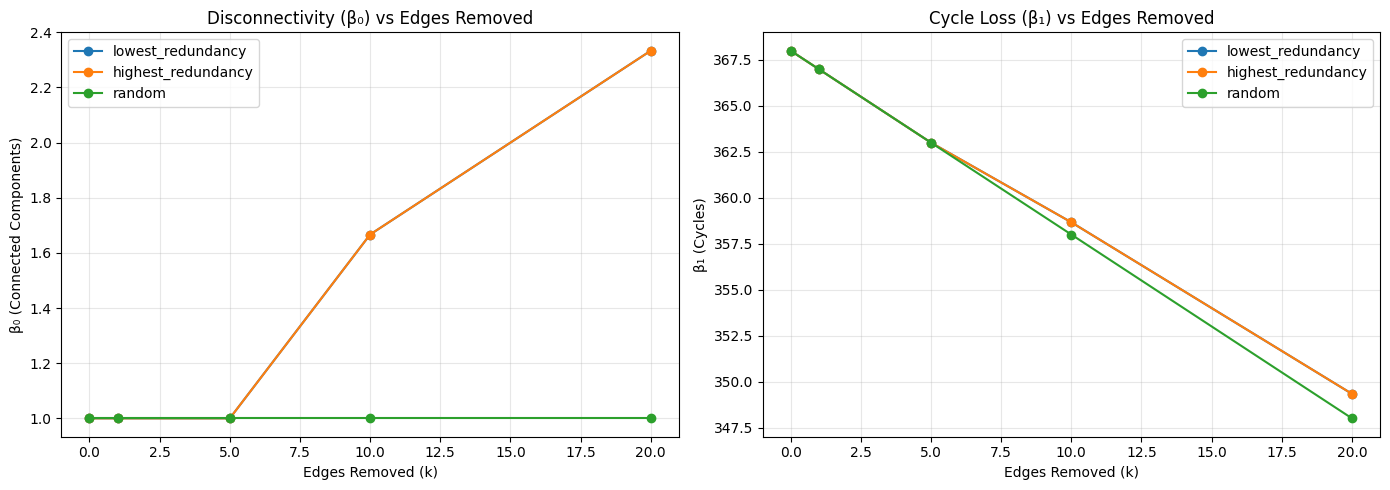

In [9]:
 # Persistence Homology Validation

import random

# Select representative graphs
print("Selecting representative graphs...")
representative_graphs = []
for data in train_data:
    if data.x.shape[0] == 100:  # Medium size preferred
        generator = getattr(data, 'generator', 'unknown')
        representative_graphs.append((data, generator))
        if len(representative_graphs) >= 3:  # One from different generators
            break

if len(representative_graphs) == 0:
    # Fallback: use any graph
    representative_graphs = [(train_data[0], getattr(train_data[0], 'generator', 'unknown'))]

print(f"Selected {len(representative_graphs)} representative graphs")

# Helper function to compute Betti numbers using NetworkX
def compute_betti_numbers(G):
    """Compute β0 (connected components) and β1 (cycles) using NetworkX."""
    # β0 = number of connected components
    beta_0 = nx.number_connected_components(G)
    
    # β1 = |E| - |V| + β0 (Euler characteristic for connected components)
    if G.number_of_nodes() == 0:
        beta_1 = 0
    else:
        num_edges = G.number_of_edges()
        num_nodes = G.number_of_nodes()
        # For each connected component: β1 = E - V + 1
        beta_1 = 0
        for comp in nx.connected_components(G):
            subgraph = G.subgraph(comp)
            comp_edges = subgraph.number_of_edges()
            comp_nodes = len(comp)
            if comp_nodes > 1:
                beta_1 += max(0, comp_edges - comp_nodes + 1)
    
    return beta_0, beta_1

# Edge removal experiment
removal_strategies = ['lowest_redundancy', 'highest_redundancy', 'random']
k_values = [1, 5, 10, 20]

results_ph = []

for data, gen_name in representative_graphs:
    print(f"\nAnalyzing graph from {gen_name} generator...")
    
    # Build graph
    edge_index = data.edge_index.numpy().T
    redundancy_scores = data.y.numpy().flatten()
    
    G_original = nx.Graph()
    edge_to_redundancy = {}
    for idx, (u, v) in enumerate(edge_index):
        u, v = int(u), int(v)
        G_original.add_edge(u, v)
        edge_to_redundancy[(u, v)] = redundancy_scores[idx]
    
    # Baseline topology
    beta_0_base, beta_1_base = compute_betti_numbers(G_original)
    
    # Rank edges by redundancy
    edges_with_redundancy = [(edge, redundancy) for edge, redundancy in edge_to_redundancy.items()]
    edges_sorted_low = sorted(edges_with_redundancy, key=lambda x: x[1])  # Lowest first
    edges_sorted_high = sorted(edges_with_redundancy, key=lambda x: x[1], reverse=True)  # Highest first
    edges_random = edges_with_redundancy.copy()
    random.shuffle(edges_random)
    
    # Edge removal experiment for each strategy
    for strategy in removal_strategies:
        G = G_original.copy()
        
        if strategy == 'lowest_redundancy':
            edges_to_remove = [e[0] for e in edges_sorted_low]
        elif strategy == 'highest_redundancy':
            edges_to_remove = [e[0] for e in edges_sorted_high]
        else:  # random
            edges_to_remove = [e[0] for e in edges_random]
        
        # Record baseline
        beta_0, beta_1 = compute_betti_numbers(G)
        results_ph.append({
            'graph': gen_name,
            'strategy': strategy,
            'k_removed': 0,
            'beta_0': beta_0,
            'beta_1': beta_1,
            'beta_0_delta': 0,
            'beta_1_delta': 0
        })
        
        # Remove edges incrementally
        for k in k_values:
            if k > len(edges_to_remove):
                continue
            
            # Remove k edges
            edges_removed = edges_to_remove[:k]
            for u, v in edges_removed:
                if G.has_edge(u, v):
                    G.remove_edge(u, v)
            
            # 4.4 Compute topology after removal
            beta_0_new, beta_1_new = compute_betti_numbers(G)
            
            results_ph.append({
                'graph': gen_name,
                'strategy': strategy,
                'k_removed': k,
                'beta_0': beta_0_new,
                'beta_1': beta_1_new,
                'beta_0_delta': beta_0_new - beta_0_base,
                'beta_1_delta': beta_1_new - beta_1_base
            })

# Analyze and plot
df_ph = pd.DataFrame(results_ph)
print("\n" + "="*60)
print("Persistence Homology Results")
print("="*60)
print(df_ph.groupby(['strategy', 'k_removed'])[['beta_0_delta', 'beta_1_delta']].mean())

# Plot persistence curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# β0 (disconnectivity) vs k
ax = axes[0]
for strategy in removal_strategies:
    mask = df_ph['strategy'] == strategy
    k_vals = sorted(df_ph.loc[mask, 'k_removed'].unique())
    beta_0_vals = [df_ph.loc[mask & (df_ph['k_removed'] == k), 'beta_0'].mean() for k in k_vals]
    ax.plot(k_vals, beta_0_vals, marker='o', label=strategy)
ax.set_xlabel('Edges Removed (k)')
ax.set_ylabel('β₀ (Connected Components)')
ax.set_title('Disconnectivity (β₀) vs Edges Removed')
ax.legend()
ax.grid(True, alpha=0.3)

# β1 (cycle loss) vs k
ax = axes[1]
for strategy in removal_strategies:
    mask = df_ph['strategy'] == strategy
    k_vals = sorted(df_ph.loc[mask, 'k_removed'].unique())
    beta_1_vals = [df_ph.loc[mask & (df_ph['k_removed'] == k), 'beta_1'].mean() for k in k_vals]
    ax.plot(k_vals, beta_1_vals, marker='o', label=strategy)
ax.set_xlabel('Edges Removed (k)')
ax.set_ylabel('β₁ (Cycles)')
ax.set_title('Cycle Loss (β₁) vs Edges Removed')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# *Training GGNs*

In [10]:
# Complete PyTorch/PyG Training Script for Edge-Level Redundancy Prediction
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GINConv, global_mean_pool, global_add_pool
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
import numpy as np
import networkx as nx
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path
import json

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# Model Definitions
# ============================================================================

class BaselineGNN(nn.Module):
    """Baseline GNN: node features + edge weights only."""
    
    def __init__(self, node_dim=3, edge_dim=2, hidden_dim=64, num_layers=3, dropout=0.1):
        super(BaselineGNN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Node feature encoder
        self.node_encoder = nn.Linear(node_dim, hidden_dim)
        
        # Graph convolution layers
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        
        # Edge feature encoder (for edge weights)
        self.edge_encoder = nn.Linear(edge_dim, hidden_dim)
        
        # Edge prediction head
        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),  # node_u + node_v + edge_feat
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Encode node features
        x = self.node_encoder(x)
        x = F.relu(x)
        
        # Graph convolutions
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = F.relu(x)
            if i < len(self.convs) - 1:
                x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Get node embeddings for each edge
        row, col = edge_index
        node_u = x[row]
        node_v = x[col]
        
        # Encode edge features
        edge_feat = self.edge_encoder(edge_attr)
        edge_feat = F.relu(edge_feat)
        
        # Concatenate and predict
        edge_embedding = torch.cat([node_u, node_v, edge_feat], dim=1)
        out = self.edge_predictor(edge_embedding)
        
        return out


class StructuralPriorGNN(nn.Module):
    """GNN with structural-prior: adds edge-level structural features."""
    
    def __init__(self, node_dim=3, edge_dim=2, struct_dim=8, hidden_dim=64, num_layers=3, dropout=0.1):
        super(StructuralPriorGNN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Node feature encoder
        self.node_encoder = nn.Linear(node_dim, hidden_dim)
        
        # Graph convolution layers
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        
        # Edge feature encoder (weights + structural features)
        self.edge_encoder = nn.Linear(edge_dim + struct_dim, hidden_dim)
        
        # Edge prediction head
        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Encode node features
        x = self.node_encoder(x)
        x = F.relu(x)
        
        # Graph convolutions
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = F.relu(x)
            if i < len(self.convs) - 1:
                x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Get node embeddings for each edge
        row, col = edge_index
        node_u = x[row]
        node_v = x[col]
        
        # Encode edge features (including structural)
        edge_feat = self.edge_encoder(edge_attr)
        edge_feat = F.relu(edge_feat)
        
        # Concatenate and predict
        edge_embedding = torch.cat([node_u, node_v, edge_feat], dim=1)
        out = self.edge_predictor(edge_embedding)
        
        return out


class TopologicalPriorGNN(nn.Module):
    """GNN with topological-prior: adds topological features."""
    
    def __init__(self, node_dim=3, edge_dim=2, topo_dim=4, hidden_dim=64, num_layers=3, dropout=0.1):
        super(TopologicalPriorGNN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Node feature encoder
        self.node_encoder = nn.Linear(node_dim, hidden_dim)
        
        # Graph convolution layers
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        
        # Edge feature encoder (weights + topological features)
        self.edge_encoder = nn.Linear(edge_dim + topo_dim, hidden_dim)
        
        # Edge prediction head
        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Encode node features
        x = self.node_encoder(x)
        x = F.relu(x)
        
        # Graph convolutions
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = F.relu(x)
            if i < len(self.convs) - 1:
                x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Get node embeddings for each edge
        row, col = edge_index
        node_u = x[row]
        node_v = x[col]
        
        # Encode edge features (including topological)
        edge_feat = self.edge_encoder(edge_attr)
        edge_feat = F.relu(edge_feat)
        
        # Concatenate and predict
        edge_embedding = torch.cat([node_u, node_v, edge_feat], dim=1)
        out = self.edge_predictor(edge_embedding)
        
        return out


class CombinedGNN(nn.Module):
    """Combined model: uses both structural and topological features."""
    
    def __init__(self, node_dim=3, edge_dim=2, struct_dim=8, topo_dim=4, 
                 hidden_dim=64, num_layers=3, dropout=0.1):
        super(CombinedGNN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Node feature encoder
        self.node_encoder = nn.Linear(node_dim, hidden_dim)
        
        # Graph convolution layers
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        
        # Edge feature encoder (weights + structural + topological)
        self.edge_encoder = nn.Linear(edge_dim + struct_dim + topo_dim, hidden_dim)
        
        # Edge prediction head
        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Encode node features
        x = self.node_encoder(x)
        x = F.relu(x)
        
        # Graph convolutions
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = F.relu(x)
            if i < len(self.convs) - 1:
                x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Get node embeddings for each edge
        row, col = edge_index
        node_u = x[row]
        node_v = x[col]
        
        # Encode edge features (including structural + topological)
        edge_feat = self.edge_encoder(edge_attr)
        edge_feat = F.relu(edge_feat)
        
        # Concatenate and predict
        edge_embedding = torch.cat([node_u, node_v, edge_feat], dim=1)
        out = self.edge_predictor(edge_embedding)
        
        return out


# ============================================================================
# Feature Computation Functions
# ============================================================================

def compute_structural_features(data):
    """Compute edge-level structural features on the fly."""
    # Handle batched data
    if hasattr(data, 'batch') and data.batch is not None:
        # Process each graph in the batch separately
        batch_size = data.batch.max().item() + 1
        all_struct_features = []
        
        for i in range(batch_size):
            # Get nodes for this graph
            node_mask = (data.batch == i)
            node_indices = torch.where(node_mask)[0]
            node_map = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(node_indices)}
            
            # Get edges for this graph
            edge_mask = node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]]
            edge_indices = torch.where(edge_mask)[0]
            
            if len(edge_indices) == 0:
                continue
            
            # Remap edge indices to local node indices
            local_edges = data.edge_index[:, edge_indices]
            local_edges = torch.tensor([[node_map[old_idx.item()] for old_idx in local_edges[0]],
                                       [node_map[old_idx.item()] for old_idx in local_edges[1]]])
            
            # Build graph
            G = nx.Graph()
            for u, v in local_edges.t().cpu().numpy():
                G.add_edge(int(u), int(v))
            
            # Node degrees and clustering
            degrees = dict(G.degree())
            clustering = nx.clustering(G)
            
            # Compute per-edge structural features
            for u, v in local_edges.t().cpu().numpy():
                u, v = int(u), int(v)
                deg_u, deg_v = degrees.get(u, 0), degrees.get(v, 0)
                clust_u, clust_v = clustering.get(u, 0.0), clustering.get(v, 0.0)
                
                # Common neighbors
                neighbors_u = set(G.neighbors(u)) if u in G else set()
                neighbors_v = set(G.neighbors(v)) if v in G else set()
                common_neighbors = len(neighbors_u & neighbors_v)
                
                # Jaccard coefficient
                union_neighbors = len(neighbors_u | neighbors_v)
                jaccard = common_neighbors / union_neighbors if union_neighbors > 0 else 0.0
                
                struct_feat = [
                    deg_u + deg_v,           # degree sum
                    min(deg_u, deg_v),       # degree min
                    max(deg_u, deg_v),       # degree max
                    clust_u + clust_v,       # clustering sum
                    min(clust_u, clust_v),   # clustering min
                    max(clust_u, clust_v),   # clustering max
                    common_neighbors,        # common neighbors
                    jaccard,                 # Jaccard coefficient
                ]
                all_struct_features.append(struct_feat)
        
        return torch.tensor(all_struct_features, dtype=torch.float32, device=data.x.device)
    else:
        # Single graph
        edge_index = data.edge_index.cpu().numpy().T
        x = data.x.cpu().numpy()
        
        # Build graph
        G = nx.Graph()
        for u, v in edge_index:
            G.add_edge(int(u), int(v))
        
        # Node degrees and clustering
        degrees = dict(G.degree())
        clustering = nx.clustering(G)
        
        # Compute per-edge structural features
        struct_features = []
        for u, v in edge_index:
            u, v = int(u), int(v)
            deg_u, deg_v = degrees.get(u, 0), degrees.get(v, 0)
            clust_u, clust_v = clustering.get(u, 0.0), clustering.get(v, 0.0)
            
            # Common neighbors
            neighbors_u = set(G.neighbors(u)) if u in G else set()
            neighbors_v = set(G.neighbors(v)) if v in G else set()
            common_neighbors = len(neighbors_u & neighbors_v)
            
            # Jaccard coefficient
            union_neighbors = len(neighbors_u | neighbors_v)
            jaccard = common_neighbors / union_neighbors if union_neighbors > 0 else 0.0
            
            struct_feat = [
                deg_u + deg_v,           # degree sum
                min(deg_u, deg_v),       # degree min
                max(deg_u, deg_v),       # degree max
                clust_u + clust_v,       # clustering sum
                min(clust_u, clust_v),   # clustering min
                max(clust_u, clust_v),   # clustering max
                common_neighbors,        # common neighbors
                jaccard,                 # Jaccard coefficient
            ]
            struct_features.append(struct_feat)
        
        return torch.tensor(struct_features, dtype=torch.float32, device=data.x.device)


def compute_topological_features(data):
    """Compute edge-level topological features on the fly."""
    # Handle batched data
    if hasattr(data, 'batch') and data.batch is not None:
        # Process each graph in the batch separately
        batch_size = data.batch.max().item() + 1
        all_topo_features = []
        
        for i in range(batch_size):
            # Get nodes for this graph
            node_mask = (data.batch == i)
            node_indices = torch.where(node_mask)[0]
            node_map = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(node_indices)}
            
            # Get edges for this graph
            edge_mask = node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]]
            edge_indices = torch.where(edge_mask)[0]
            
            if len(edge_indices) == 0:
                continue
            
            # Remap edge indices to local node indices
            local_edges = data.edge_index[:, edge_indices]
            local_edges = torch.tensor([[node_map[old_idx.item()] for old_idx in local_edges[0]],
                                       [node_map[old_idx.item()] for old_idx in local_edges[1]]])
            
            # Build graph
            G = nx.Graph()
            for u, v in local_edges.t().cpu().numpy():
                G.add_edge(int(u), int(v))
            
            # Bridges
            bridges = set(nx.bridges(G))
            
            # Compute per-edge topological features
            for u, v in local_edges.t().cpu().numpy():
                u, v = int(u), int(v)
                
                # Is bridge
                is_bridge = 1.0 if (u, v) in bridges or (v, u) in bridges else 0.0
                
                # Triangle count (common neighbors)
                neighbors_u = set(G.neighbors(u)) if u in G else set()
                neighbors_v = set(G.neighbors(v)) if v in G else set()
                triangle_count = len(neighbors_u & neighbors_v)
                
                # In cycle (not a bridge)
                in_cycle = 1.0 - is_bridge
                
                # Square count (4-cycles) - approximate via two-hop paths
                square_count = 0
                for neighbor in neighbors_u:
                    if neighbor != v:
                        neighbor_neighbors = set(G.neighbors(neighbor)) if neighbor in G else set()
                        if v in neighbor_neighbors:
                            square_count += 1
                
                topo_feat = [
                    is_bridge,
                    triangle_count,
                    in_cycle,
                    square_count,
                ]
                all_topo_features.append(topo_feat)
        
        return torch.tensor(all_topo_features, dtype=torch.float32, device=data.x.device)
    else:
        # Single graph
        edge_index = data.edge_index.cpu().numpy().T
        
        # Build graph
        G = nx.Graph()
        for u, v in edge_index:
            G.add_edge(int(u), int(v))
        
        # Compute per-edge topological features
        topo_features = []
        
        # Bridges
        bridges = set(nx.bridges(G))
        
        for u, v in edge_index:
            u, v = int(u), int(v)
            
            # Is bridge
            is_bridge = 1.0 if (u, v) in bridges or (v, u) in bridges else 0.0
            
            # Triangle count (common neighbors)
            neighbors_u = set(G.neighbors(u)) if u in G else set()
            neighbors_v = set(G.neighbors(v)) if v in G else set()
            triangle_count = len(neighbors_u & neighbors_v)
            
            # In cycle (not a bridge)
            in_cycle = 1.0 - is_bridge
            
            # Square count (4-cycles) - approximate via two-hop paths
            square_count = 0
            for neighbor in neighbors_u:
                if neighbor != v:
                    neighbor_neighbors = set(G.neighbors(neighbor)) if neighbor in G else set()
                    if v in neighbor_neighbors:
                        square_count += 1
            
            topo_feat = [
                is_bridge,
                triangle_count,
                in_cycle,
                square_count,
            ]
            topo_features.append(topo_feat)
        
        return torch.tensor(topo_features, dtype=torch.float32, device=data.x.device)


def augment_data_with_features(data, model_type):
    """Augment data with structural/topological features based on model type."""
    edge_attr_original = data.edge_attr.clone()
    
    if model_type == 'baseline':
        # No augmentation needed
        data.edge_attr = edge_attr_original
    elif model_type == 'structural':
        struct_feat = compute_structural_features(data)
        data.edge_attr = torch.cat([edge_attr_original, struct_feat], dim=1)
    elif model_type == 'topological':
        topo_feat = compute_topological_features(data)
        data.edge_attr = torch.cat([edge_attr_original, topo_feat], dim=1)
    elif model_type == 'combined':
        struct_feat = compute_structural_features(data)
        topo_feat = compute_topological_features(data)
        data.edge_attr = torch.cat([edge_attr_original, struct_feat, topo_feat], dim=1)
    
    return data


# ============================================================================
# Training Functions
# ============================================================================

def train_epoch(model, loader, optimizer, criterion, device, model_type):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch in tqdm(loader, desc="Training", leave=False):
        batch = batch.to(device)
        batch = augment_data_with_features(batch, model_type)
        
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches if num_batches > 0 else 0.0


def evaluate(model, loader, device, model_type):
    """Evaluate model."""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating", leave=False):
            batch = batch.to(device)
            batch = augment_data_with_features(batch, model_type)
            
            out = model(batch)
            all_preds.append(out.cpu().numpy())
            all_targets.append(batch.y.cpu().numpy())
    
    preds = np.concatenate(all_preds, axis=0).flatten()
    targets = np.concatenate(all_targets, axis=0).flatten()
    
    # Remove NaNs
    mask = ~(np.isnan(preds) | np.isnan(targets))
    preds = preds[mask]
    targets = targets[mask]
    
    mse = mean_squared_error(targets, preds)
    mae = mean_absolute_error(targets, preds)
    spearman_r, _ = spearmanr(targets, preds) if len(preds) > 1 else (0.0, 1.0)
    
    return {
        'mse': mse,
        'mae': mae,
        'spearman_r': spearman_r,
        'preds': preds,
        'targets': targets
    }


def train_model(model, train_loader, val_loader, test_loader, model_type, 
                num_epochs=100, lr=0.001, weight_decay=1e-5, patience=20):
    """Complete training loop."""
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                          factor=0.5, patience=10)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    
    print(f"\nTraining {model_type} model...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(num_epochs):
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device, model_type)
        train_losses.append(train_loss)
        
        # Validate
        val_metrics = evaluate(model, val_loader, device, model_type)
        val_loss = val_metrics['mse']
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), f'models/{model_type}_best.pt')
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, "
                  f"Val Loss={val_loss:.4f}, Val Spearman={val_metrics['spearman_r']:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(torch.load(f'models/{model_type}_best.pt'))
    
    # Final evaluation
    print("\nFinal Evaluation:")
    train_metrics = evaluate(model, train_loader, device, model_type)
    val_metrics = evaluate(model, val_loader, device, model_type)
    test_metrics = evaluate(model, test_loader, device, model_type)
    
    results = {
        'model_type': model_type,
        'best_epoch': best_epoch,
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    return model, results


# ============================================================================
# Main Training Script
# ============================================================================

def train():
    """Main training function."""
    # Create directories
    os.makedirs('models', exist_ok=True)
    os.makedirs('results', exist_ok=True)
    
    # Load datasets
    print("Loading datasets...")
    train_data = torch.load('synthetic-graphs/train.pt', weights_only=False)
    val_data = torch.load('synthetic-graphs/val.pt', weights_only=False)
    test_data = torch.load('synthetic-graphs/test.pt', weights_only=False)
    
    print(f"Train: {len(train_data)} graphs")
    print(f"Val: {len(val_data)} graphs")
    print(f"Test: {len(test_data)} graphs")
    
    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    
    # Model configurations
    node_dim = 3
    edge_dim = 2
    struct_dim = 8
    topo_dim = 4
    hidden_dim = 64
    num_layers = 3
    
    models_config = {
        'baseline': BaselineGNN(node_dim, edge_dim, hidden_dim, num_layers),
        'structural': StructuralPriorGNN(node_dim, edge_dim, struct_dim, hidden_dim, num_layers),
        'topological': TopologicalPriorGNN(node_dim, edge_dim, topo_dim, hidden_dim, num_layers),
        'combined': CombinedGNN(node_dim, edge_dim, struct_dim, topo_dim, hidden_dim, num_layers)
    }
    
    # Train all models
    all_results = {}
    
    for model_type, model in models_config.items():
        print(f"\n{'='*60}")
        print(f"Training {model_type.upper()} model")
        print(f"{'='*60}")
        
        trained_model, results = train_model(
            model, train_loader, val_loader, test_loader, model_type,
            num_epochs=100, lr=0.001, weight_decay=1e-5, patience=20
        )
        
        all_results[model_type] = results
        
        # Print summary
        print(f"\n{model_type.upper()} Results:")
        print(f"  Train - MSE: {results['train']['mse']:.4f}, "
              f"MAE: {results['train']['mae']:.4f}, "
              f"Spearman: {results['train']['spearman_r']:.4f}")
        print(f"  Val   - MSE: {results['val']['mse']:.4f}, "
              f"MAE: {results['val']['mae']:.4f}, "
              f"Spearman: {results['val']['spearman_r']:.4f}")
        print(f"  Test  - MSE: {results['test']['mse']:.4f}, "
              f"MAE: {results['test']['mae']:.4f}, "
              f"Spearman: {results['test']['spearman_r']:.4f}")
    
    # Save results
    results_summary = {}
    for model_type, results in all_results.items():
        results_summary[model_type] = {
            'best_epoch': results['best_epoch'],
            'train_mse': float(results['train']['mse']),
            'train_mae': float(results['train']['mae']),
            'train_spearman': float(results['train']['spearman_r']),
            'val_mse': float(results['val']['mse']),
            'val_mae': float(results['val']['mae']),
            'val_spearman': float(results['val']['spearman_r']),
            'test_mse': float(results['test']['mse']),
            'test_mae': float(results['test']['mae']),
            'test_spearman': float(results['test']['spearman_r'])
        }
    
    with open('results/training_results.json', 'w') as f:
        json.dump(results_summary, f, indent=2)
    
    # Plot training curves
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, (model_type, results) in enumerate(all_results.items()):
        ax = axes[idx]
        ax.plot(results['train_losses'], label='Train', alpha=0.7)
        ax.plot(results['val_losses'], label='Val', alpha=0.7)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE Loss')
        ax.set_title(f'{model_type.upper()} Model')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Plot comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    model_types = list(all_results.keys())
    metrics = ['mse', 'mae', 'spearman_r']
    metric_labels = ['MSE', 'MAE', 'Spearman r']
    
    for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
        ax = axes[idx]
        test_values = [all_results[mt]['test'][metric] for mt in model_types]
        
        bars = ax.bar(model_types, test_values, alpha=0.7)
        ax.set_ylabel(label)
        ax.set_title(f'Test {label} Comparison')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, val in zip(bars, test_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('results/model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*60)
    print("Training Complete!")
    print("="*60)
    print(f"Results saved to results/training_results.json")
    print(f"Models saved to models/")
    print(f"Plots saved to results/")
    
    return all_results


# Training script is ready - call main() from the next cell to run


Using device: cpu


Starting training for all 4 models...
Loading datasets...
Train: 434 graphs
Val: 93 graphs
Test: 93 graphs

Training BASELINE model

Training baseline model...
Model parameters: 27,393


Epoch 10/100: Train Loss=64.7876, Val Loss=60.6896, Val Spearman=0.2472


Epoch 20/100: Train Loss=62.5643, Val Loss=57.5427, Val Spearman=0.3235


Epoch 30/100: Train Loss=62.2438, Val Loss=58.4463, Val Spearman=0.3596


Epoch 40/100: Train Loss=60.9853, Val Loss=56.0470, Val Spearman=0.3673


Epoch 50/100: Train Loss=59.1554, Val Loss=55.1688, Val Spearman=0.3891


Epoch 60/100: Train Loss=60.0660, Val Loss=53.3800, Val Spearman=0.4108


Epoch 70/100: Train Loss=49.2583, Val Loss=51.8937, Val Spearman=0.4840


Epoch 80/100: Train Loss=44.5152, Val Loss=57.1552, Val Spearman=0.4134


Epoch 90/100: Train Loss=42.7268, Val Loss=52.5266, Val Spearman=0.4572


Epoch 100/100: Train Loss=41.9028, Val Loss=48.6604, Val Spearman=0.4968

Final Evaluation:



BASELINE Results:
  Train - MSE: 41.7708, MAE: 4.2521, Spearman: 0.5673
  Val   - MSE: 47.3109, MAE: 4.5350, Spearman: 0.4827
  Test  - MSE: 43.5521, MAE: 4.6968, Spearman: 0.5633

Training STRUCTURAL model

Training structural model...
Model parameters: 27,905


Epoch 10/100: Train Loss=64.8656, Val Loss=62.1998, Val Spearman=0.1176


Epoch 20/100: Train Loss=60.1327, Val Loss=58.4315, Val Spearman=0.2545


Epoch 30/100: Train Loss=59.0914, Val Loss=58.7044, Val Spearman=0.2391


Epoch 40/100: Train Loss=57.3699, Val Loss=54.3058, Val Spearman=0.3941


Epoch 50/100: Train Loss=54.3503, Val Loss=52.6932, Val Spearman=0.4155


Epoch 60/100: Train Loss=54.2694, Val Loss=51.6619, Val Spearman=0.4381


Epoch 70/100: Train Loss=56.7416, Val Loss=56.4711, Val Spearman=0.3708


Epoch 80/100: Train Loss=50.0148, Val Loss=49.6292, Val Spearman=0.4681


Epoch 90/100: Train Loss=48.9848, Val Loss=50.3716, Val Spearman=0.4519


Epoch 100/100: Train Loss=49.2893, Val Loss=48.7068, Val Spearman=0.4632

Final Evaluation:



STRUCTURAL Results:
  Train - MSE: 43.7247, MAE: 4.3144, Spearman: 0.5572
  Val   - MSE: 48.7068, MAE: 4.5230, Spearman: 0.4632
  Test  - MSE: 46.1802, MAE: 4.7590, Spearman: 0.5632

Training TOPOLOGICAL model

Training topological model...
Model parameters: 27,649


Epoch 10/100: Train Loss=63.3262, Val Loss=61.4571, Val Spearman=0.1988


Epoch 20/100: Train Loss=61.5330, Val Loss=59.4354, Val Spearman=0.2261


Epoch 30/100: Train Loss=61.7907, Val Loss=57.2935, Val Spearman=0.2642


Epoch 40/100: Train Loss=59.0112, Val Loss=55.4706, Val Spearman=0.3026


Epoch 50/100: Train Loss=60.3250, Val Loss=58.8261, Val Spearman=0.2192


Epoch 60/100: Train Loss=56.6575, Val Loss=56.2521, Val Spearman=0.3566


Epoch 70/100: Train Loss=51.6824, Val Loss=53.7639, Val Spearman=0.3811


Epoch 80/100: Train Loss=45.2656, Val Loss=49.0109, Val Spearman=0.4411


Epoch 90/100: Train Loss=46.0553, Val Loss=51.5211, Val Spearman=0.4494


Epoch 100/100: Train Loss=41.7425, Val Loss=48.5321, Val Spearman=0.4668

Final Evaluation:



TOPOLOGICAL Results:
  Train - MSE: 42.6717, MAE: 4.3000, Spearman: 0.5505
  Val   - MSE: 48.3857, MAE: 4.5442, Spearman: 0.4583
  Test  - MSE: 44.9418, MAE: 4.7185, Spearman: 0.5593

Training COMBINED model

Training combined model...
Model parameters: 28,161


Epoch 10/100: Train Loss=63.1627, Val Loss=62.0790, Val Spearman=0.1464


Epoch 20/100: Train Loss=61.6210, Val Loss=60.0784, Val Spearman=0.2503


Epoch 30/100: Train Loss=56.5334, Val Loss=56.9786, Val Spearman=0.3168


Epoch 40/100: Train Loss=55.9314, Val Loss=54.1199, Val Spearman=0.3806


Epoch 50/100: Train Loss=54.8330, Val Loss=53.2745, Val Spearman=0.4093


Epoch 60/100: Train Loss=53.7645, Val Loss=53.7325, Val Spearman=0.4104


Epoch 70/100: Train Loss=52.7435, Val Loss=58.0634, Val Spearman=0.3886


Epoch 80/100: Train Loss=50.1171, Val Loss=51.9688, Val Spearman=0.4390


Epoch 90/100: Train Loss=51.1379, Val Loss=51.4190, Val Spearman=0.4614


Epoch 100/100: Train Loss=51.0955, Val Loss=50.7108, Val Spearman=0.4592

Final Evaluation:



COMBINED Results:
  Train - MSE: 48.1441, MAE: 4.7684, Spearman: 0.4775
  Val   - MSE: 50.2970, MAE: 4.7544, Spearman: 0.4648
  Test  - MSE: 49.6133, MAE: 5.1486, Spearman: 0.4860


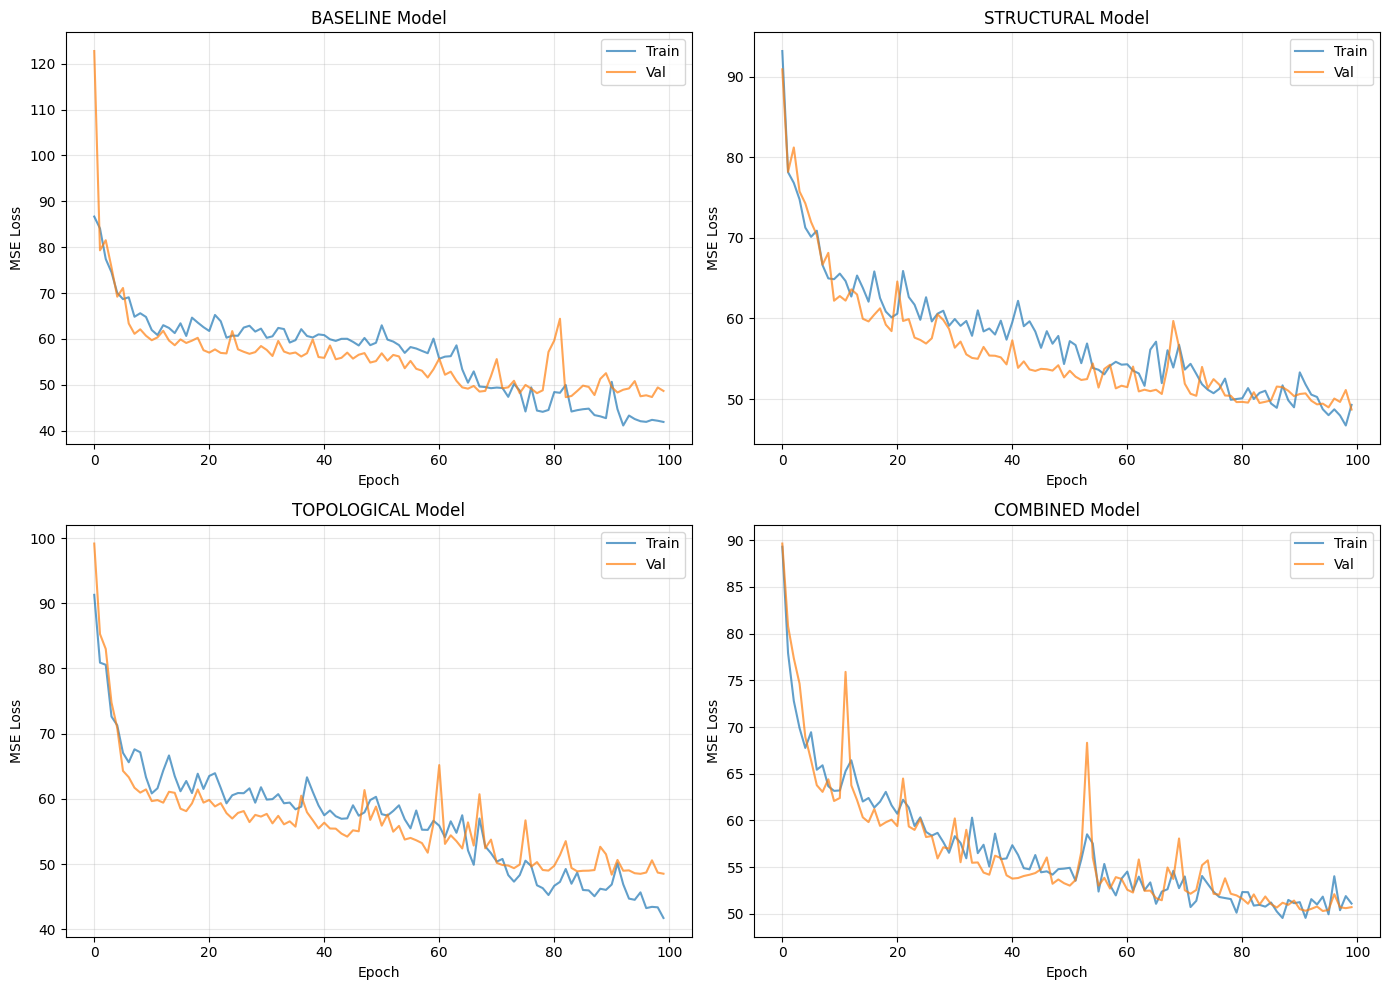

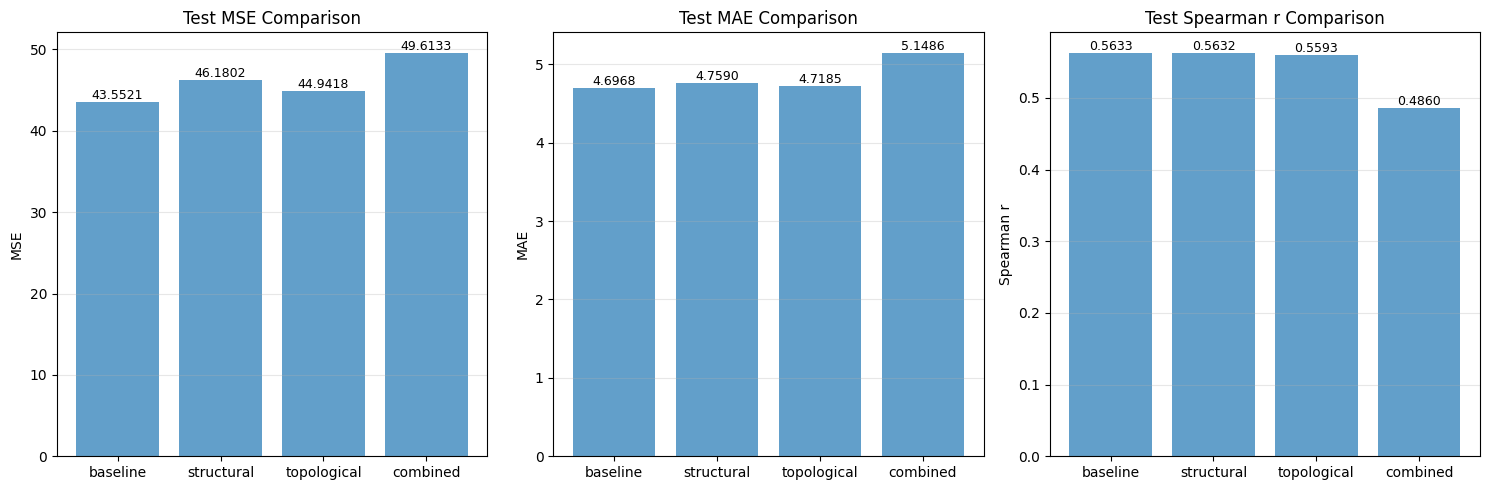


Training Complete!
Results saved to results/training_results.json
Models saved to models/
Plots saved to results/


In [11]:
# Run training for all models
print("Starting training for all 4 models...")
print("="*60)

# Execute the training
results = train()


results will tell us about whether topology or structure better encodes redundancy in a network?

# *Testing Models on a Real Supply Chain Dataset*